In [18]:
#!/usr/bin/python
# -*- coding: utf-8 -*-

# Enter the symbol and condition to use
symbol = "PIVX:BTC:daily"

# Enter your API key for Gatsiva

apikey = "<your_api_key>"

In [4]:
# Import utility libraries we will need
import requests
import json
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from __future__ import division
from datetime import datetime
from performance import create_sharpe_ratio, create_drawdowns

In [5]:
# Ignore warnings
warnings.filterwarnings('ignore')

# Allow matplotlib to render inline (needed for pandas plotting)
%matplotlib inline

***Retrieving the data from Gatsiva API***

In [6]:
bearer_token = 'Bearer ' + apikey
my_headers = {'Accept': 'application/json', 'Authorization': bearer_token}
analytic = requests.get('https://api.gatsiva.com/api/v1/symbols/' + symbol,headers=my_headers)
results = analytic.json()['results']    
data = pd.DataFrame.from_dict(results, orient='index')
dates = []
for n in data.index:
    dates.append(datetime.utcfromtimestamp(int(n)+86400))
data.index = dates

In [7]:
print(data.head())

                high     close      open       low     volume
2017-02-14  0.000034  0.000027  0.000026  0.000018  565201.92
2017-02-15  0.000028  0.000024  0.000027  0.000024  243218.90
2017-02-16  0.000028  0.000023  0.000024  0.000020  486603.19
2017-02-17  0.000030  0.000022  0.000023  0.000021  105969.62
2017-02-18  0.000028  0.000022  0.000022  0.000020  272557.57


***Creating a list of summary statistics for PIVX:BTC:daily***

In [8]:
returns = data["close"].pct_change()
annual_sharpe = create_sharpe_ratio(returns, periods=365)
equity_curve = (1.0+returns).cumprod()
total_return = equity_curve[-1]
drawdowns, max_dd, dd_duration = create_drawdowns(equity_curve)
stats = [("Total Return", "%0.2f%%" % ((total_return - 1.0) * 100.0)),
                 ("Annual Sharpe Ratio", "%0.2f" % annual_sharpe),
                 ("Max Drawdown", "%0.2f%%" % (max_dd * 100.0)),
                 ("Drawdown Duration", "%d" % dd_duration)]
print(stats)

[('Total Return', '1910.57%'), ('Annual Sharpe Ratio', '2.28'), ('Max Drawdown', '86.02%'), ('Drawdown Duration', '322')]


***Plotting the data***

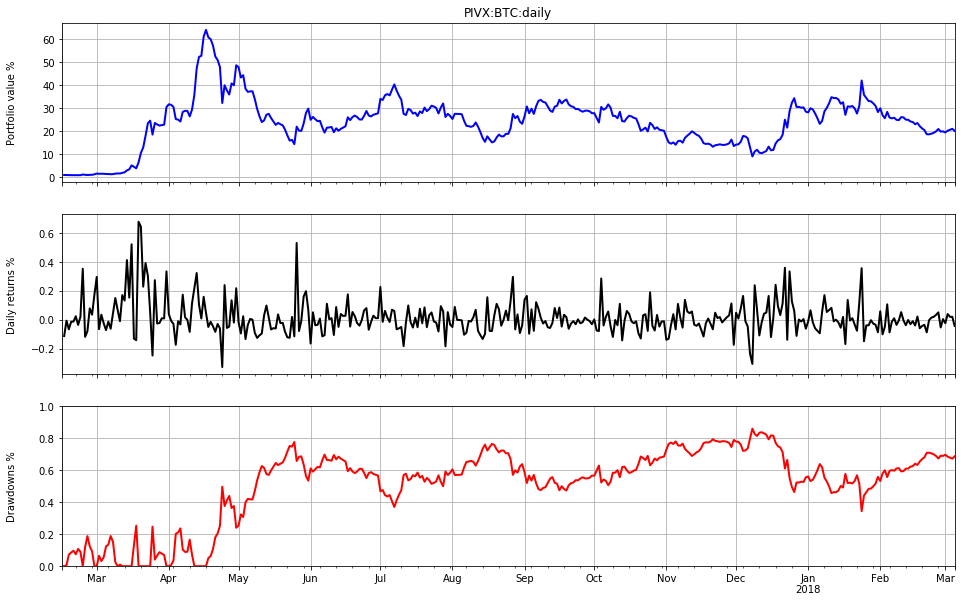

In [9]:
fig = plt.figure(figsize=(16,10))
#plot the equity curve
ax1 = fig.add_subplot(311, ylabel="Portfolio value %")
equity_curve.plot(ax=ax1, color = "blue", lw=2.)
ax1.set_title('PIVX:BTC:daily')
ax1.get_yaxis().set_label_coords(-0.05,0.5)
plt.grid(True)
#plot the daily returns
ax2 = fig.add_subplot(312, ylabel="Daily returns %")            
returns.plot(ax =ax2, color = "black", lw=2.,sharex=ax1)
ax2.get_yaxis().set_label_coords(-0.05,0.5)
plt.grid(True)
#plot the drawdowns
ax3 = fig.add_subplot(313, ylabel="Drawdowns %")
drawdowns.plot(ax=ax3, color = "red", lw=2.,sharex=ax1)
ax3.get_yaxis().set_label_coords(-0.05,0.5)
plt.ylim(0,1)
plt.grid(True)

#plt.subplots_adjust(hspace=0.5)

***Finding the Signals***

The first thing we have to do is define the signal conditions in Python language. Basically, we want to test this strategy:
    * if bottom(day) < bottom(day-1) and close(day) > close(day-1) => BUY
    * if top(day) > top(day-1) and close(day) < close(day-1) => SELL
    
This can be done easily:

In [10]:
newdf = data.copy()
l = len(newdf)
#buying signal condition
div = [0]
for i in range(1,l):
    if newdf.iloc[i]["low"] < newdf.iloc[i-1]["low"] and newdf.iloc[i]["close"] > newdf.iloc[i-1]["close"]:
        div.append(1)
    else:
        div.append(0)
newdf["buy"] = div
#selling signal condition
div = [0]
for i in range(1,l):
    if newdf.iloc[i]["high"] > newdf.iloc[i-1]["high"] and newdf.iloc[i]["close"] < newdf.iloc[i-1]["close"]:
        div.append(1)
    else:
        div.append(0)
newdf["sell"] = div

***Creating illustrations of when the events occurred***
    

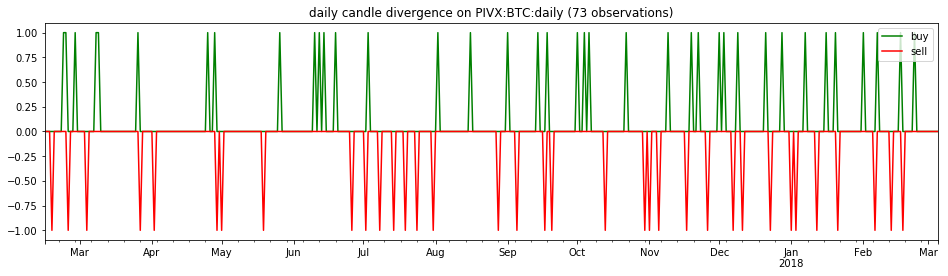

In [11]:
buying_count = newdf["buy"][newdf["buy"] == 1].count()
selling_count = newdf["sell"][newdf["sell"] == 1].count()
title = "daily candle divergence on " + symbol + " (" + str(buying_count + selling_count) + " observations)"
newdf["buy"].plot(legend=True, figsize=(16,4), title=title, color = "green")
(-newdf["sell"]).plot(legend=True, figsize=(16,4),color ="red")

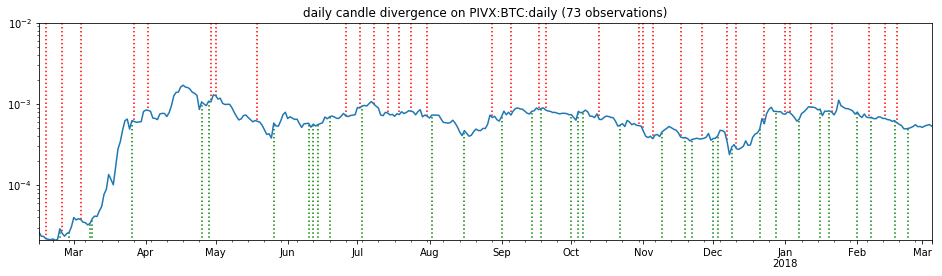

In [12]:
#Plottig the signals into the price history curve (log scale)
newdf["close"].plot(figsize=(16,4))
plt.yscale('log')
plt.ylim(0,10**-2)
plt.vlines(newdf.index[newdf["buy"] == 1],0,newdf["close"][newdf["buy"] == 1],linestyles="dotted", color ="green")
plt.vlines(newdf.index[newdf["sell"] == 1],10**-2,newdf["close"][newdf["sell"] == 1],linestyles="dotted", color = "red")
plt.title(title)

Now we want to create a new dataframe called "trading_history" which track the outcome of each trade and remove “clustering” of events, areas where the event occurs repeatedly for a period of time. Indeed, we won't rebuy at a dip nor consolidate our position when already exposed.

In [13]:
#creating a temporary dataframe listing only events
trading_history = newdf[(newdf["buy"] == 1) | (newdf["sell"] == 1)]
trading_history = trading_history[["close", "buy", "sell"]]
#removing consecutive buying or selling signals
idxs = []
for i in range(0,len(trading_history)-1):
    if trading_history.iloc[i]["buy"] == trading_history.iloc[i+1]["buy"]:        
        idxs.append(i+1)
trading_history = trading_history.drop(trading_history.index[idxs])

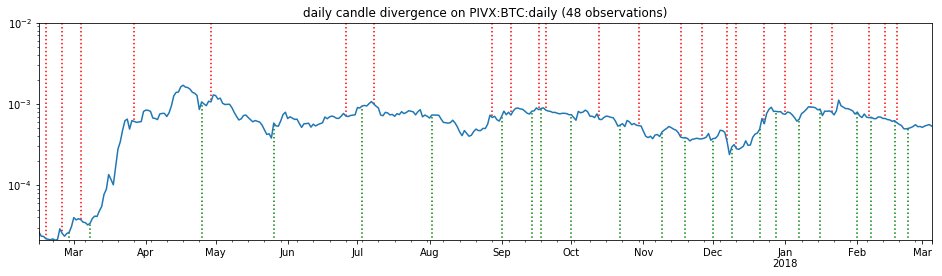

In [14]:
#plotting again into the price history curve (log scale)
new_buying_count = trading_history["buy"][trading_history["buy"] == 1].count()
new_selling_count = trading_history["sell"][trading_history["sell"] == 1].count()
title = "daily candle divergence on " + symbol + " (" + str(new_buying_count + new_selling_count) + " observations)"
newdf["close"].plot(figsize=(16,4))
plt.yscale('log')
plt.ylim(0,10**-2)
plt.vlines(
    trading_history.index[trading_history["buy"] == 1],
    0,
    trading_history["close"][trading_history["buy"] == 1],
    linestyles="dotted",
    color ="green")
plt.vlines(
    trading_history.index[trading_history["sell"] == 1],
    10**-2,
    trading_history["close"][trading_history["sell"] == 1],
    linestyles="dotted",
    color = "red")
plt.title(title)

In [15]:
#adding two new columns: "exit" = price at which we would have closed the trade (selling signal) following this strategy 
#and "returns" (outcome)
trading_history["exit"] = trading_history["close"].shift(-1)
trading_history["returns"] = None
try:    
    trading_history["returns"] = (trading_history["exit"] - trading_history["close"]) / trading_history["close"]    
except Exception:
    pass
#removing all selling raws (we are not interested in short selling) and creating the final dataframe
buying_history = trading_history[trading_history["buy"] == 1].drop(labels="sell", axis = 1)
buying_history.tail()

,close,buy,exit,returns
2018-01-16,0.000863,1,0.000793,-0.080862
2018-02-01,0.000794,1,0.000678,-0.146652
2018-02-07,0.000685,1,0.000662,-0.033732
2018-02-17,0.000624,1,0.000587,-0.058852
2018-02-23,0.000500,1,NaN,NaN


Note that we are bullish on PIVX since 23 February !

Right now we want to compare our strategy returns with the basic buy and hold strategy:

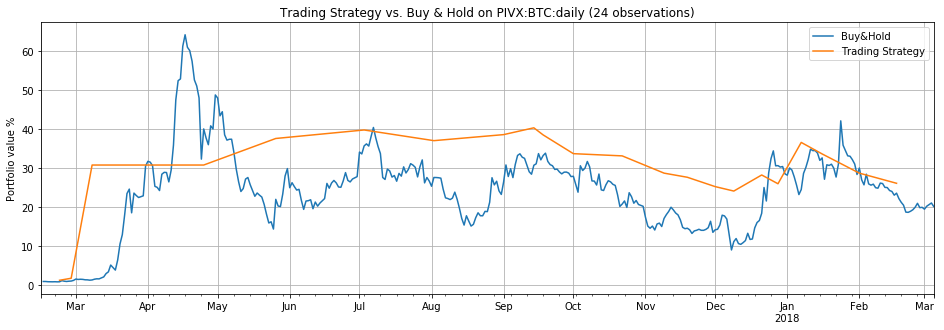

In [16]:
#plotting again the buy & hold equity curve
plt.figure(figsize=(16,5))
plt.ylabel("Portfolio value %")
equity_curve.plot(label='Buy&Hold')
#plotting our strategy
strat_total_count = len(buying_history)
strat_returns = buying_history["returns"]
strat_equity_curve = (1.0+strat_returns).cumprod()
strat_equity_curve.plot(label="Trading Strategy")
title = "Trading Strategy vs. Buy & Hold on " + symbol + " (" + str(strat_total_count) +  " observations)"
plt.title(title)
plt.legend()
plt.grid()

Our total return is slightly above the Buy & Hold strategy total return, but what about the drawdowns ?
Recall that for Buy & Hold strategy the max drawdown was 86.02% and the max duration was 322 days.
Following our strategy instead of just buy and hold, we would have experimented less drawdowns:

In [17]:
strat_drawdowns, strat_max_dd, strat_dd_duration = create_drawdowns(strat_equity_curve)
print(["Max drawdown", "%0.2f%%" % (strat_max_dd*100.0),
       "Max duration", "%d" % (strat_dd_duration)])

['Max drawdown', '40.25%', 'Max duration', '15']


***Conclusion***

This strategy seems to perform pretty well for PIVX:BTC, but:
* We didn't remove the outlier (2017-03-08, return = 1697%), despite the fact this outlier obviously creates an important bias in the average return of this strategy.
* We have only 24 observations.

On the other side, if we consider, folllowing Nassim Nicholas Taleb's concept, that Cryptoland is likely somewhere in "Extremistan", we shouldn't remove such an outlier in our study as this strategy managed (maybe by luck?) to capture the big bull run who occurred on March 2017 for PIVX.

Instead of ending all trades at a selling signal, another approach could consist of the following:
1. The study of the cumulative returns by looking at what happened after the first time the buying signal occurred (until 30 days after the entry signal for example).
2. The build of confidence intervals.